# Manually Selection of the Most Likely Causal Genes from Significant TWAS Genes

## Aim

Genomewide MR was skipped due to missing `MAF` column in the imputed GWAS sumstats, and our [TWAS pipeline](https://github.com/rl3328/xqtl-protocol/blob/main/code/pecotmr_integration/twas_ctwas.ipynb) runs TWAS and MR in the same step (`twas`). This notebook serves as a quick rescue to manually diminish noise from LD hitchhiking and identify the most likely causal genes.



## Steps

### 1. Filter genes qualified for MR analysis

Most thresholds follow the default requirements in \[`twas`], except I use a stricter `twas_pval` cutoff. The reason is that I want to directly apply the filter to “significant” TWAS genes in my manuscript while also saving resources.

**Criteria:**

1. Strong and reliable TWAS signals:

   * `twas_pval < 2.5*1e-6`
   * `rsq_cv > 0.01`
   * `rsq_pval < 0.05`
2. Strong GWAS signals:

   * Have `CS`, which can be extracted from `twas_weight(.rds)` files

### 2. Manually select the most likely causal gene

Within each LD block and by context, I define the gene with the strongest GWAS signal as follows:

* For each gene–context combination:

  * If no credible set (CS) is available, skip (this corresponds to filtering step 1.2).
  * If a 95% CS exists, select the gene containing the variant with the highest PIP within the 95% CS. If not, fall back to 70% CS.
  * If a 70% CS exists, select the gene containing the variant with the highest PIP within the 70% CS. If not, fall back to 50% CS.
  * If a 50% CS exists, select the gene containing the variant with the highest PIP within the 50% CS.



## Note

There are some differences between this identification and the [loose gene list](https://github.com/rl3328/xqtl-analysis/blob/main/production/image_QTL/interested_genes/TWAS_QTL/loose_gene/image_Aging4_gene_list.tsv).

* Loose list: 42 genes, filtered by `is_selected_method` and `twas_pval < 2.5*1e-6`
* Current identification: 443 genes are strong TWAS genes(twas_pval < 2.5*1e-6 & rsq_cv > 0.01 & pval_cv < 0.05) for Aging4 and Knight cohort, 48 genes were identified as the final list.



## Input

1. **Merged TWAS results** (`*.twas.tsv.gz`):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/rl3328/image_QTL/twas/image_Aging4_twas_merged.tsv.gz.combined_twas.tsv.gz`
2. **xQTL\_meta\_file** (meta file specifying TWAS weight paths by cohort):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv`


## Plan

Other GWAS studies and other cohorts will be analyzed in the same way.


In [37]:
library(data.table)
library(tidyverse)
library(pecotmr)

In [38]:
setwd("~/data")

In [39]:
##Bonfferroni correction is too strict
# Aging4_twas = fread("~/project/image_QTL/twas/multiple_testing/image_Aging4_twas_bonff.bonf_corrected.tsv.gz")


In [40]:
Aging4_twas = fread("~/project/image_QTL/twas/image_Aging4_twas_merged.tsv.gz.combined_twas.tsv.gz")


In [5]:
# weight_db_list = fread("~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv")


In [6]:
# No gene presents in multiple blocks
genes_in_multiple_blocks <- Aging4_twas %>% group_by(molecular_id) %>% summarise(
    number_of_blocks = n_distinct(block)) %>%
    filter(number_of_blocks > 1)

print(genes_in_multiple_blocks)

# A tibble: 0 × 2
# ℹ 2 variables: molecular_id <chr>, number_of_blocks <int>


In [6]:
head(Aging4_twas)
dim(Aging4_twas)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging4,enet,TRUE,FALSE,0.098757440,8.923911e-10,-2.925529,0.003438716,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging4,lasso,TRUE,FALSE,0.103370596,3.541036e-10,-2.953063,0.003146377,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging4,mrash,TRUE,FALSE,0.089177838,6.013310e-09,-2.792398,0.005231890,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging4,susie,TRUE,TRUE,0.121638427,8.766557e-12,-2.932920,0.003357909,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging4,enet,TRUE,FALSE,0.007872702,5.201216e-02,1.188241,0.234738536,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging4,lasso,TRUE,FALSE,0.006195072,7.447581e-02,1.045410,0.295833712,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz


[1] 928827     19

In [41]:
# Strong and reliable TWAS signals:
Aging4_twas_filtered <- Aging4_twas |>
    filter(
        twas_pval < 2.5*1e-6 &     # Stricter p-value threshold 
        rsq_cv > 0.01 &          # Cross-validation R²
        pval_cv < 0.05          # R² significance
    )
Aging4_block = unique(Aging4_twas_filtered$block)

In [42]:
dim(Aging4_twas_filtered)

[1] 255  19

In [43]:
most_likely_causal_genes = Aging4_twas_filtered |> 
  group_by(context, region) |> 
  slice_max(abs(twas_z), n = 1)

In [44]:
head(most_likely_causal_genes)
dim(most_likely_causal_genes)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
16,ENSG00000258839,89913417,85040000,90338345,AC_DeJager_eQTL,image_Aging4,mvsusie,TRUE,FALSE,0.08744415,1.185243e-13,4.850124,1.233842e-06,eQTL,chr16_88382277_90220225,chr16_88382277_90220225,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr16_88382277_90220225.twas.tsv.gz
17,ENSG00000141298,29930275,28360000,32440000,AC_DeJager_eQTL,image_Aging4,mrmash,TRUE,FALSE,0.03974159,5.899385e-07,-5.008127,5.496234e-07,eQTL,chr17_27951253_31594410,chr17_27951253_31594410,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr17_27951253_31594410.twas.tsv.gz
17,ENSG00000136448,44957991,42560000,46680000,AC_DeJager_eQTL,image_Aging4,susie,TRUE,FALSE,0.18908461,5.732138e-29,-4.791365,1.656504e-06,eQTL,chr17_42087601_45383525,chr17_42087601_45383525,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr17_42087601_45383525.twas.tsv.gz
19,ENSG00000126267,35648322,32720000,43520000,AC_DeJager_eQTL,image_Aging4,enet,TRUE,FALSE,0.23413037,2.390473e-36,4.829141,1.371233e-06,eQTL,chr19_35206200_36997570,chr19_35206200_36997570,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr19_35206200_36997570.twas.tsv.gz
1,ENSG00000142609,2003836,0,6480000,AC_DeJager_eQTL,image_Aging4,lasso,TRUE,FALSE,0.07050705,3.005085e-11,-4.959468,7.068655e-07,eQTL,chr1_16103_2888443,chr1_16103_2888443,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr1_16103_2888443.twas.tsv.gz
1,ENSG00000162877,205850131,201840000,206850132,AC_DeJager_eQTL,image_Aging4,bayes_l,TRUE,FALSE,0.33760717,4.702438e-55,5.528340,3.232757e-08,eQTL,chr1_204142966_205972031,chr1_204142966_205972031,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr1_204142966_205972031.twas.tsv.gz


[1] 82 19

In [45]:
most_likely_causal_genes |> count(molecular_id) |> nrow()

[1] 82

In [46]:
Aging4_gene = unique(most_likely_causal_genes$molecular_id)

In [47]:
image_Aging4_gene_list <- Aging4_twas |> 
  dplyr::filter(molecular_id %in% Aging4_gene) |> 
  dplyr::mutate(`#chr` = paste0("chr", chr), molecular_id = molecular_id) |> 
  dplyr::select(`#chr`, start, end, molecular_id) |> 
  unique()

In [48]:
dim(image_Aging4_gene_list)

[1] 41  4

In [49]:
DNE_QTL_gene = fread("~/project/image_QTL/twas/annotated_dne_gene.tsv")


In [50]:
image_Aging4_QTL_gene = DNE_QTL_gene |> filter(str_detect(event_ID, "image_Aging4")) |> dplyr::select(-strand,-event_ID)
                                        

In [51]:
image_Aging4_gene = bind_rows(image_Aging4_gene_list, image_Aging4_QTL_gene)

In [52]:
fwrite(image_Aging4_gene, "~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging4_gene_list.tsv", sep = '\t')

### image_Aging4_QTL list

In [53]:

library(clusterProfiler)
library(org.Hs.eg.db)


In [54]:
image_Aging4_gene = fread("~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging4_gene_list.tsv")

In [55]:
Aging4_sig_gene_ego <- enrichGO(
  gene          = unique(image_Aging4_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [56]:
head(Aging4_sig_gene_ego, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:2000279,GO:2000279,negative regulation of DNA biosynthetic process,2/39,41/21261,0.002569760,0.3427465,0.318717,ENSG00000107960/ENSG00000082482,2
GO:0016233,GO:0016233,telomere capping,2/39,42/21261,0.002695131,0.3427465,0.318717,ENSG00000107960/ENSG00000139579,2
GO:0010639,GO:0010639,negative regulation of organelle organization,4/39,405/21261,0.006304105,0.3427465,0.318717,ENSG00000107960/ENSG00000185324/ENSG00000141298/ENSG00000283154,4
GO:0002752,GO:0002752,cell surface pattern recognition receptor signaling pathway,2/39,74/21261,0.008148296,0.3427465,0.318717,ENSG00000126262/ENSG00000276600,2
GO:0009314,GO:0009314,response to radiation,4/39,465/21261,0.010148833,0.3427465,0.318717,ENSG00000258839/ENSG00000136448/ENSG00000157764/ENSG00000139579,4
GO:0048678,GO:0048678,response to axon injury,2/39,84/21261,0.010396109,0.3427465,0.318717,ENSG00000157764/ENSG00000082482,2
GO:0033044,GO:0033044,regulation of chromosome organization,3/39,280/21261,0.014561084,0.3427465,0.318717,ENSG00000107960/ENSG00000108604/ENSG00000139579,3
GO:0002220,GO:0002220,innate immune response activating cell surface receptor signaling pathway,2/39,107/21261,0.016471299,0.3427465,0.318717,ENSG00000126262/ENSG00000276600,2
GO:2000234,GO:2000234,positive regulation of rRNA processing,1/39,10/21261,0.018196587,0.3427465,0.318717,ENSG00000115368,1


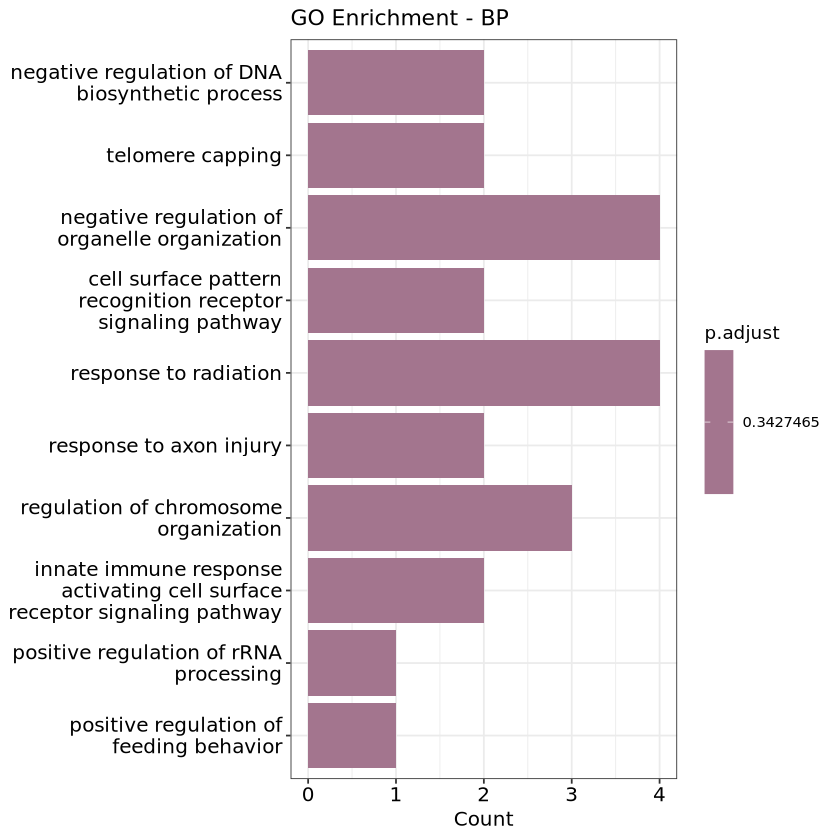

In [57]:
barplot(Aging4_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [58]:
Aging4_sig_gene_ego_cc <- enrichGO(
  gene          = unique(image_Aging4_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [59]:
head(Aging4_sig_gene_ego_cc, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0042564,GO:0042564,NLS-dependent protein nuclear import complex,1/41,11/22568,0.01980785,0.3114111,0.2800631,ENSG00000182481,1
GO:0140092,GO:0140092,bBAF complex,1/41,11/22568,0.01980785,0.3114111,0.2800631,ENSG00000108604,1
GO:0000782,GO:0000782,telomere cap complex,1/41,13/22568,0.02336792,0.3114111,0.2800631,ENSG00000107960,1
GO:0000783,GO:0000783,nuclear telomere cap complex,1/41,13/22568,0.02336792,0.3114111,0.2800631,ENSG00000107960,1
GO:0031074,GO:0031074,nucleocytoplasmic transport complex,1/41,13/22568,0.02336792,0.3114111,0.2800631,ENSG00000182481,1
GO:0097550,GO:0097550,transcription preinitiation complex,1/41,13/22568,0.02336792,0.3114111,0.2800631,ENSG00000141425,1
GO:0140445,GO:0140445,"chromosome, telomeric repeat region",1/41,14/22568,0.02514323,0.3114111,0.2800631,ENSG00000107960,1
GO:0035060,GO:0035060,brahma complex,1/41,15/22568,0.02691538,0.3114111,0.2800631,ENSG00000108604,1
GO:0016586,GO:0016586,RSC-type complex,1/41,16/22568,0.02868439,0.3114111,0.2800631,ENSG00000108604,1


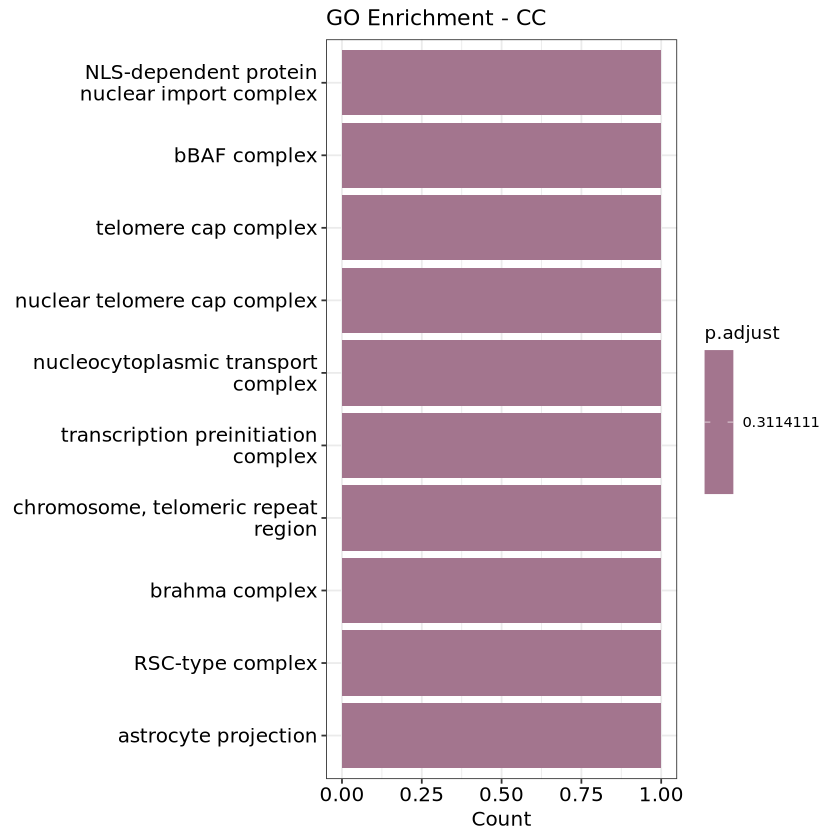

In [60]:
barplot(Aging4_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [61]:
image_Aging4_sig_gene_ego_mf <- enrichGO(
  gene          = unique(image_Aging4_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [62]:
head(image_Aging4_sig_gene_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0043047,GO:0043047,single-stranded telomeric DNA binding,2/40,12/21059,0.0002293973,0.02454545,0.01971292,ENSG00000107960/ENSG00000139579,2
GO:0098847,GO:0098847,sequence-specific single stranded DNA binding,2/40,15/21059,0.0003636363,0.02454545,0.01971292,ENSG00000107960/ENSG00000139579,2
GO:0042162,GO:0042162,telomeric DNA binding,2/40,40/21059,0.0026214417,0.11796488,0.09473982,ENSG00000107960/ENSG00000139579,2
GO:0106310,GO:0106310,protein serine kinase activity,4/40,377/21059,0.0055568387,0.18429395,0.14800996,ENSG00000185324/ENSG00000157764/ENSG00000164543/ENSG00000112739,4
GO:0004674,GO:0004674,protein serine/threonine kinase activity,4/40,467/21059,0.0116167425,0.18429395,0.14800996,ENSG00000185324/ENSG00000157764/ENSG00000164543/ENSG00000112739,4
GO:0019531,GO:0019531,oxalate transmembrane transporter activity,1/40,10/21059,0.0188367132,0.18429395,0.14800996,ENSG00000174502,1
GO:0045322,GO:0045322,unmethylated CpG binding,1/40,10/21059,0.0188367132,0.18429395,0.14800996,ENSG00000272333,1
GO:0098505,GO:0098505,G-rich strand telomeric DNA binding,1/40,10/21059,0.0188367132,0.18429395,0.14800996,ENSG00000139579,1
GO:0099122,GO:0099122,RNA polymerase II C-terminal domain binding,1/40,10/21059,0.0188367132,0.18429395,0.14800996,ENSG00000141425,1


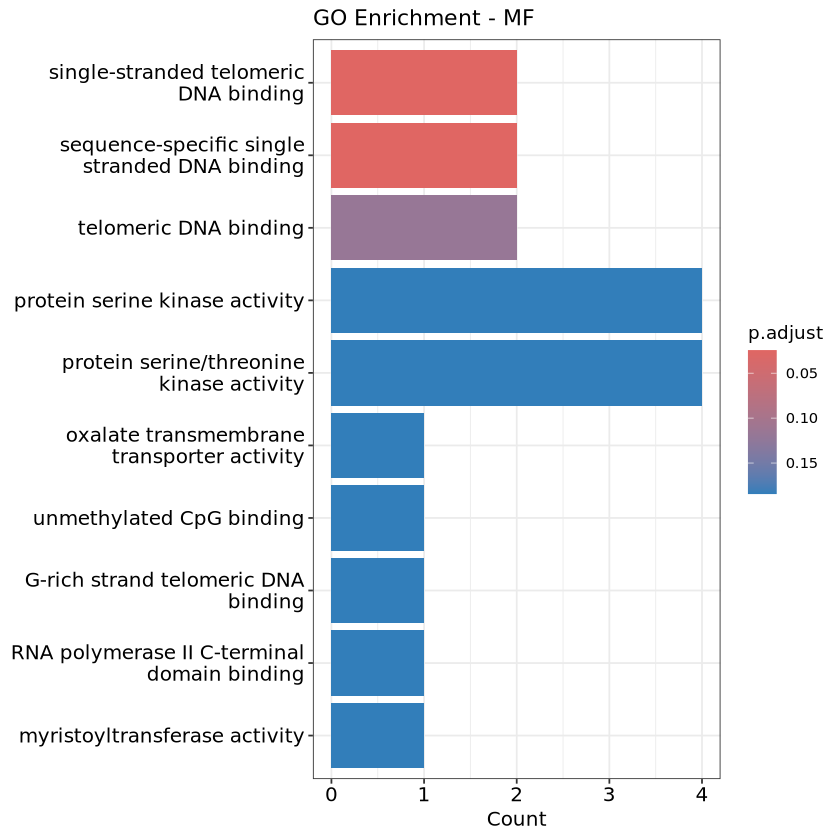

In [63]:
barplot(image_Aging4_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [64]:
entrez_ids <- bitr(image_Aging4_gene$molecular_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(image_Aging4_gene$molecular_id, fromType = "ENSEMBL", toType = "ENTREZID", :
“2.38% of input gene IDs are fail to map...”


In [65]:
kegg_enrich %>% head(n=20)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04024,Environmental Information Processing,Signal transduction,hsa04024,cAMP signaling pathway,3/18,226/9446,0.008455645,0.3423355,0.3288223,673/2867/3776,3
hsa05208,Human Diseases,Cancer: overview,hsa05208,Chemical carcinogenesis - reactive oxygen species,3/18,227/9446,0.008558681,0.3423355,0.3288223,1340/115019/673,3
hsa04270,Organismal Systems,Circulatory system,hsa04270,Vascular smooth muscle contraction,2/18,134/9446,0.026344454,0.3423355,0.3288223,673/553,2
hsa04934,Human Diseases,Endocrine and metabolic disease,hsa04934,Cushing syndrome,2/18,155/9446,0.034464879,0.3423355,0.3288223,673/3776,2
hsa05160,Human Diseases,Infectious disease: viral,hsa05160,Hepatitis C,2/18,159/9446,0.036110697,0.3423355,0.3288223,673/439996,2
hsa05225,Human Diseases,Cancer: specific types,hsa05225,Hepatocellular carcinoma,2/18,170/9446,0.040792273,0.3423355,0.3288223,6603/673,2
hsa00900,Metabolism,Metabolism of terpenoids and polyketides,hsa00900,Terpenoid backbone biosynthesis,1/18,23/9446,0.042970540,0.3423355,0.3288223,9453,1
hsa04015,Environmental Information Processing,Signal transduction,hsa04015,Rap1 signaling pathway,2/18,212/9446,0.060605903,0.3423355,0.3288223,673/285,2
hsa04081,NA,NA,hsa04081,Hormone signaling,2/18,219/9446,0.064181923,0.3423355,0.3288223,4157/553,2


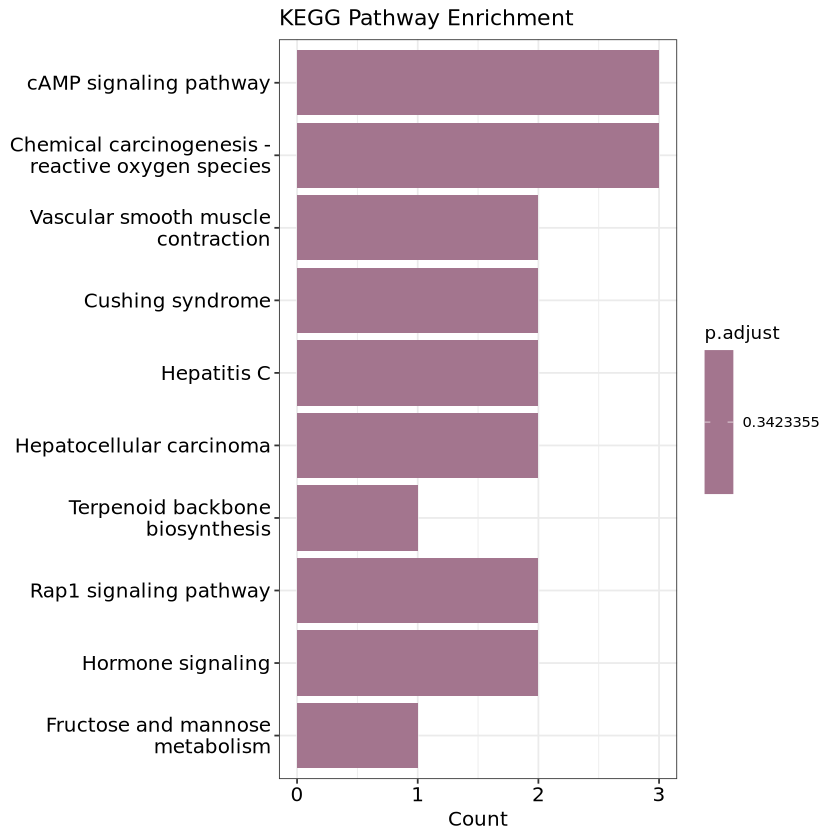

In [66]:
barplot(kegg_enrich, showCategory = 10, title = "KEGG Pathway Enrichment")